In [1]:
# make sure pillow is installed
!pip install Pillow



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import PIL
PIL.__version__

'9.4.0'

In [3]:
import pytanis
# Be aware that this notebook might only run with the following version
pytanis.__version__

'0.2.post1.dev21+gb5363b0.d20230217'

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
import math
import logging
import structlog
import tomli
from pathlib import Path

import numpy as np

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_context("poster")
sns.set(rc={"figure.figsize": (16, 9.)})
sns.set_style("whitegrid")

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)


In [5]:
# Set the logging level
logging.basicConfig(level=logging.WARNING, stream=sys.stdout)

# Import event-specific settings to don't have them here in the notebook
with open('config.toml', 'rb') as fh:
    cfg = tomli.load(fh)

In [6]:
from PIL import Image, ImageDraw, ImageFont
from pytanis.utils import implode
from pytanis.review import Col
from pytanis import PretalxClient
from pytanis.pretalx import speakers_as_df, subs_as_df
from collections import namedtuple
import time

In [7]:
# taken from https://gist.github.com/digitaltembo/eb7c8a7fdef987e6689ee8de050720c4

ALLIGNMENT_LEFT = 0
ALLIGNMENT_CENTER = 1
ALLIGNMENT_RIGHT = 2
ALLIGNMENT_TOP = 3
ALLIGNMENT_BOTTOM = 4


def text_box(text, image_draw, font, box, horizontal_allignment=ALLIGNMENT_LEFT, vertical_allignment=ALLIGNMENT_TOP, **kwargs):
    """write text in the box by breaking down the string on multiple lines"""
    x = box[0]
    y = box[1]
    width = box[2]
    height = box[3]
    lines = text.split('\n')
    true_lines = []
    for line in lines:
        if font.getsize(line)[0] <= width:
            true_lines.append(line)
        else:
            current_line = ''
            for word in line.split(' '):
                if font.getsize(current_line + word)[0] <= width:
                    current_line += ' ' + word
                else:
                    true_lines.append(current_line)
                    current_line = word
            true_lines.append(current_line)

    x_offset = y_offset = 0
    lineheight = font.getsize(true_lines[0])[1] * 1.2  # Give a margin of 0.2x the font height
    if vertical_allignment == ALLIGNMENT_CENTER:
        y = int(y + height / 2)
        y_offset = - (len(true_lines) * lineheight) / 2
    elif vertical_allignment == ALLIGNMENT_BOTTOM:
        y = int(y + height)
        y_offset = - (len(true_lines) * lineheight)

    for line in true_lines:
        linewidth = font.getsize(line)[0]
        if horizontal_allignment == ALLIGNMENT_CENTER:
            x_offset = (width - linewidth) / 2
        elif horizontal_allignment == ALLIGNMENT_RIGHT:
            x_offset = width - linewidth
        image_draw.text(
            (int(x + x_offset), int(y + y_offset)),
            line,
            font=font,
            **kwargs
        )
        y_offset += lineheight


def font(font_path, size=12):
    """load font file (*.ttf) and return an image font to write text box with text"""
    return ImageFont.truetype(font_path, size=size, encoding="unic")


In [8]:
TalkInfo = namedtuple("talkinfo", ["name", "affiliation", "title", "key"])

 # see readme inside the folder se see how to modify the template
template_path = "./40_talk_image/template.png"
font_path = "./40_talk_image/Roboto-Regular.ttf"


In [9]:
def create_social_card(talkInfo: TalkInfo):
    """create soclai card from template by adding the title, authors and affilition"""
    img = Image.open(template_path)
    imgDraw = ImageDraw.Draw(img)

    text_box(
        text=talkInfo.title,
        image_draw=imgDraw,
        font=font(font_path, 40),
        box=(80, 200, 650, 300),
        horizontal_allignment=ALLIGNMENT_RIGHT,
        vertical_allignment=ALLIGNMENT_CENTER,
        fill="#eb9041",
    )

    text_box(
        text=talkInfo.name,
        image_draw=imgDraw,
        font=font(font_path, 20),
        box=(80, 475, 650, 475),
        horizontal_allignment=ALLIGNMENT_RIGHT,
        fill="#000000",
    )

    text_box(
        text=talkInfo.affiliation,
        image_draw=imgDraw,
        font=font(font_path, 15),
        box=(80, 500, 650, 500),
        horizontal_allignment=ALLIGNMENT_RIGHT,
        fill="#000000",
    )

    text_box(
        text=talkInfo.key,
        image_draw=imgDraw,
        font=font(font_path, 10),
        box=(900, 500, 900, 500),
        fill="#aaaaaa",
    )

    return img.resize((1200, 630))


In [10]:
# load speaker and submission from pretalx
pretalx_client = PretalxClient(blocking=True)
pkrs_count, spkrs = pretalx_client.speakers(cfg['event_name'], params={"questions": "all"})
subs_count, subs = pretalx_client.submissions(cfg['event_name'], params={"questions": "all", "state": ["confirmed", "accepted"]})

  0%|          | 0/333 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

In [11]:
# create the dataframe from raw pretalx api result
spkrs_df = speakers_as_df(spkrs, with_questions=True)
subs_df = subs_as_df(subs, with_questions=True)


In [12]:
# join submission and speakers together 
subs_df = subs_df.explode([Col.speaker_code, Col.speaker_name])
subs_df = pd.merge(subs_df, spkrs_df.drop(columns=[Col.speaker_name, Col.submission]), on=Col.speaker_code)
subs_df = implode(subs_df, [col for col in spkrs_df if col not in [Col.submission]])


In [13]:
# create all the social cards for all the talks and write them in 40_talk_image/output/ folder
for _, submission in subs_df.iterrows():
    # get all speakers from a talk togethers
    names = " & ".join(submission["Speaker name"])
    # we only want the affiliation if it is not nan
    affiliation_list = submission["Q: Company / Institute"]
    affiliation = " " if np.nan in affiliation_list else " & ".join(affiliation_list)
    affiliation = affiliation.replace("\n", "")
    # other attributes where no preprocessing is needed
    title = submission["Title"]
    key = submission["Submission"]
    talkInfo = TalkInfo(
        name=names,
        affiliation=affiliation,
        title=submission["Title"],
        key=key,
    )
    img = create_social_card(talkInfo)
    img.save(f"40_talk_image/output/{key}.png")
    
    # small break between 2 image to not overwhelm old laptop
    time.sleep(0.1)


/var/folders/79/04017qsd7vs6pmdn2drbx1qh0000gn/T/ipykernel_78410/2229113366.py:19: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  if font.getsize(line)[0] <= width:
/var/folders/79/04017qsd7vs6pmdn2drbx1qh0000gn/T/ipykernel_78410/2229113366.py:24: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  if font.getsize(current_line + word)[0] <= width:
/var/folders/79/04017qsd7vs6pmdn2drbx1qh0000gn/T/ipykernel_78410/2229113366.py:32: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  lineheight = font.getsize(true_lines[0])[1] * 1.2  # Give a margin of 0.2x the font height
/var/folders/79/04017qsd7vs6pmdn2drbx1qh0000gn/T/ipykernel_78410/2229113366.py:41: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength ins

In [14]:
# all done! You just need to copy the output folder in ./notebooks/40_talk_image/output into the wwww repo, under website/assets/static/media/twitter

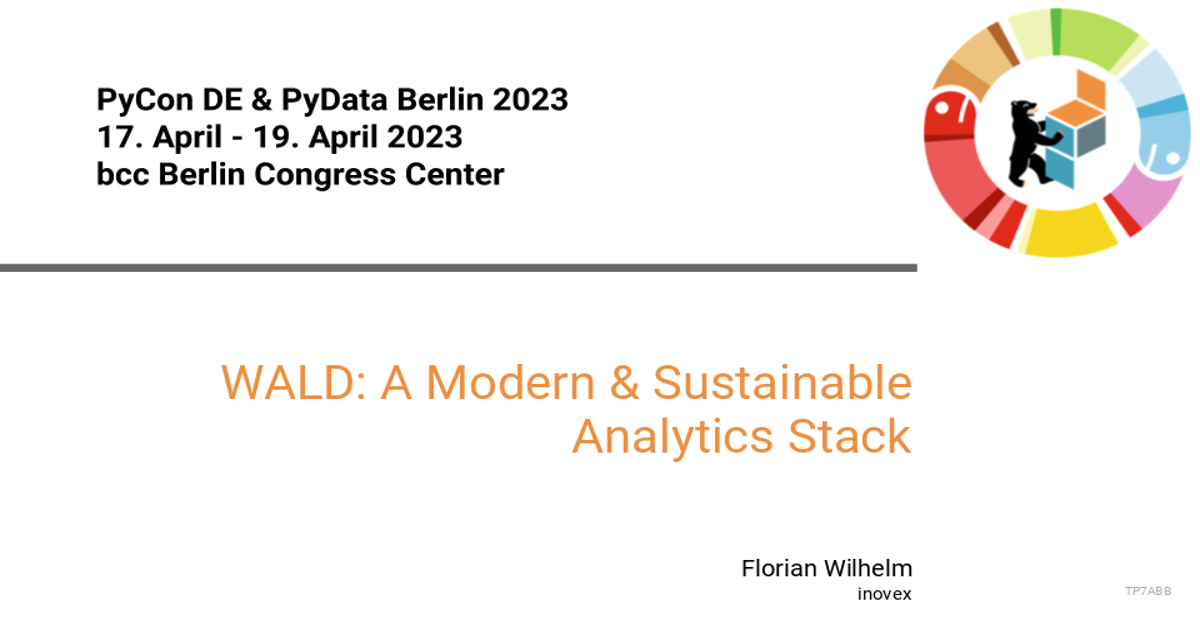

In [15]:
# Display an example of what was created above.
from IPython.display import Image
Image("40_talk_image/output/TP7ABB.png")